## Packages

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from pytrends.request import TrendReq
import pytrends
from random import randint
import pmdarima as pm
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

## Functions

In [29]:
def get_data(state, abb, kw_list):
    """takes state, state abbreviation from Google Trends 
    and keyword list as inputs and returns DataFrame
    containing ili rates for the state and Google Trends data
    for the keywords"""
    
     # ili data
    states_ili = pd.read_csv("ili_state_level.csv", header=0)
    states_ili["date"] = pd.to_datetime(states_ili.week.astype(str) + states_ili.year.astype(str).add("-0"), format="%W%Y-%w")
    states_ili.set_index("date", inplace=True)
    ili = states_ili.loc[states_ili["region"]==state,:]
    ili = ili.shift(-1, freq='W')
    ili = ili.drop(["Unnamed: 0", "weighted_ili", "age_0_4", "age_25_49", "age_25_64", "age_5_24", "age_50_64", "age_65", "week_start"], axis=1)
    
     # Google Trends
    geo = "US-" + str(abb)
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(kw_list, cat=0, timeframe="2014-09-29 2019-07-07", geo=geo)
    trends = pytrends.interest_over_time()
    trends = trends.drop("isPartial", axis=1)
    
    # merge the dataframes on the Datetimeindex
    merged = trends.join(ili)
    merged = merged.asfreq("W")
    
    return merged




def get_usdata(kw_list):
    """takes keyword list as input and returns DataFrame
    containing ili rates for the state and Google Trends 
    data for the keywords"""
    
    # ili data
    us_ili = pd.read_csv("ili_national_level.csv", header=0)
    us_ili["date"] = pd.to_datetime(us_ili.week.astype(str) + us_ili.year.astype(str).add("-0"), format="%W%Y-%w")
    us_ili.set_index("date", inplace=True)
    ili = us_ili.shift(-1, freq='W')
       
    
    # Google Trends
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(kw_list, cat=0, timeframe="2015-01-11 2019-07-07", geo="US")
    trends = pytrends.interest_over_time()
    trends = trends.drop("isPartial", axis=1)
    
    # merge the dataframes on the Datetimeindex
    merged = trends.join(ili)
    merged["unweighted_ili"] = merged["unweighted_ili"].interpolate(method="linear")
    merged = merged.drop(merged.tail(4).index, inplace=False)
    merged = merged.asfreq("W")
    
    return merged




def correlation(df, kw):
    """takes dataframe and column name (i.e. a keyword) as input and returns
    the correlation between unweighted ili and the keyword search volume"""
    
    corr = df["unweighted_ili"].corr(df[kw])
    return corr
    
    
    
    
def corr_coefficients(state, abb, kw_list):
    """takes state , state abbreviation from Google Trends 
    and keyword list as inputs and returns correlation coefficients
    of ili rates and Google Trends keywords"""
    
    # ili data
    states_ili = pd.read_csv("ili_state_level.csv", header=0)
    states_ili["date"] = pd.to_datetime(states_ili.week.astype(str) + states_ili.year.astype(str).add("-0"), format="%W%Y-%w")
    states_ili.set_index("date", inplace=True)
    ili = states_ili.loc[states_ili["region"]==state,:]
    ili = ili.shift(-1, freq='W')
    
    # Google Trends
    geo = "US-" + str(abb)
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(kw_list, cat=0, timeframe="2014-09-29 2019-07-07", geo=geo)
    trends = pytrends.interest_over_time()
    trends = trends.drop("isPartial", axis=1)
    
    # merge the dataframes on the Datetimeindex
    merged = trends.join(ili)
        
    # correlation coefficients
    for var in kw_list:
        print("Corr. Coef. between unweighted_ili and " + var + " for " + str(state) + ": " + str(merged["unweighted_ili"].corr(merged[var])))

        
        
        
def add_weekdummies(df):
    df["week"] = df["week"].astype("category")
    new = pd.get_dummies(df, columns=["week"], drop_first=True)
    
    return new




def ts_data(df):
    clean = df.drop(['Unnamed: 0', 'region_type', 'region', 'year', 'week', 'weighted_ili', 'age_0_4', 'age_25_49', 'age_25_64', 'age_5_24', 'age_50_64', 'age_65', 'ilitotal', 'num_of_providers', 'total_patients', 'week_start'], axis=1)
    
    return clean




def lagged_ili(df, n=1):
    """takes dataframe with ili rates and google trends time series data as input and returns
    dataframe containing the same data, but unweighted_ili shifted n periods back"""
    
    df["unweighted_ili"].index = df["unweighted_ili"].index-n
    lagged = pd.concat([df.drop(columns=["unweighted_ili"]), df["unweighted_ili"]], axis=1)
    
    return lagged
    
    
    
    
def rmse(test, pred):
    return np.sqrt(mean_squared_error(test, pred))

## Exploration

In [21]:
# defining a keyword list to use for Google Trends
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]

In [22]:
ili_us = get_usdata(kw_list)
ili = ts_data(ili_us)

In [23]:
ili.corr()

,fever,flu,cough,sore throat,headache,unweighted_ili
fever,1.000000,0.776799,0.810527,0.752714,0.514962,0.916061
flu,0.776799,1.000000,0.694233,0.557790,0.509461,0.841355
cough,0.810527,0.694233,1.000000,0.884537,0.549330,0.852225
sore throat,0.752714,0.557790,0.884537,1.000000,0.524308,0.735037
headache,0.514962,0.509461,0.549330,0.524308,1.000000,0.453791
unweighted_ili,0.916061,0.841355,0.852225,0.735037,0.453791,1.000000


In [52]:
# correlation with lagged ili rates
lagged = lagged_ili(ili)
lagged.corr()

,fever,flu,cough,sore throat,headache,unweighted_ili
fever,1.000000,0.766814,0.820430,0.766704,0.527942,0.896157
flu,0.766814,1.000000,0.695559,0.556787,0.509802,0.840559
cough,0.820430,0.695559,1.000000,0.877285,0.541196,0.875556
sore throat,0.766704,0.556787,0.877285,1.000000,0.496289,0.737180
headache,0.527942,0.509802,0.541196,0.496289,1.000000,0.458557
unweighted_ili,0.896157,0.840559,0.875556,0.737180,0.458557,1.000000


## Forecasting

### Univariate Forecasting

In [3]:
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
ili_us = get_usdata(kw_list)
ili = ili_us["unweighted_ili"]

# defining train and test / forecasting data
train = ili.iloc[:179]
test = ili.iloc[179:]

#### SARIMA - using Auto Arima

In [28]:
# first test using Auto Arima
arima = pm.auto_arima(train, start_p=1, start_q=1, m=52, seasonal=True, trace=1, error_action="ignore")

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=622.949, BIC=629.323, Fit time=0.024 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=114.114, BIC=123.676, Fit time=0.100 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 52); AIC=35.574, BIC=48.323, Fit time=0.324 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 52); AIC=16.891, BIC=36.015, Fit time=0.403 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 52); AIC=23.240, BIC=39.177, Fit time=0.300 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 52); AIC=14.899, BIC=30.836, Fit time=0.276 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 0, 0, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIM

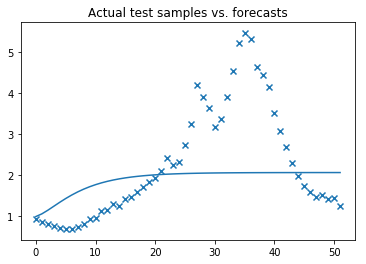

In [29]:
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

#### SARIMA more Data

In [40]:
data = pd.read_csv("ili_national_more.csv", header=0)
data["date"] = pd.to_datetime(data.week.astype(str) + data.year.astype(str).add("-0"), format="%W%Y-%w")
data.set_index("date", inplace=True)
data = data.shift(-1, freq='W')
data = data.drop(['Unnamed: 0', 'region_type', 'region', 'year', 'week', 'weighted_ili',
       'age_0_4', 'age_25_49', 'age_25_64', 'age_5_24',
       'age_50_64', 'age_65', 'ilitotal', 'num_of_providers', 'total_patients',
       'week_start'], axis=1)
data = data.loc[~data.index.duplicated(keep='first')]
data = data.asfreq("W")

train2 = data.iloc[:772]
train2 = train2.fillna(method="ffill")
test2 = data.iloc[772:]
test2 = test2.fillna(method="ffill")

In [42]:
# first test using Auto Arima
arima = pm.auto_arima(train2, start_p=1, start_q=1, m=52, seasonal=True, trace=1, error_action="ignore")

C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 52); AIC=203.232, BIC=231.149, Fit time=75.321 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=2391.911, BIC=2401.217, Fit time=0.052 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=421.672, BIC=440.283, Fit time=121.456 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=1442.175, BIC=1460.787, Fit time=18.940 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=247.988, BIC=271.252, Fit time=33.175 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 1, 52); AIC=202.060, BIC=234.630, Fit time=337.462 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 0, 52); AIC=202.458, BIC=230.375, Fit time=1477.125 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 2, 52); AIC=294.877, BIC=332.100, Fit time=425.109 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 0, 52); AIC=224.355, BIC=247.619, Fit time=147.046 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 0, 1) seasonal_order=(2, 0, 1, 52); AIC=1279.231, BIC=1307.148, Fit time=333.255 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 0, 1, 52); AIC=154.112, BIC=191.335, Fit time=414.167 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 1, 52); AIC=152.931, BIC=185.501, Fit time=350.363 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 1) seasonal_order=(2, 0, 1, 52); AIC=156.834, BIC=198.709, Fit time=497.628 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=153.048, BIC=180.965, Fit time=66.788 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 0, 52); AIC=153.560, BIC=181.477, Fit time=1668.855 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 2, 52); AIC=243.070, BIC=280.293, Fit time=442.590 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=173.906, BIC=197.170, Fit time=154.737 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 52); AIC=375.050, BIC=402.967, Fit time=282.096 seconds


C:\Users\Tobi\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 0) seasonal_order=(2, 0, 1, 52); AIC=154.287, BIC=191.510, Fit time=445.482 seconds
Total fit time: 7291.739 seconds


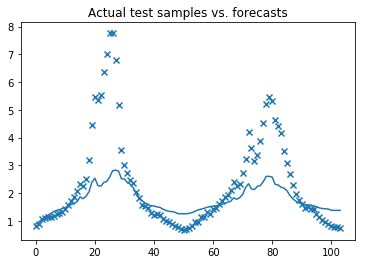

In [45]:
y = np.arange(test2.shape[0])
plt.scatter(y, test2, marker='x')
plt.plot(y, arima.predict(n_periods=test2.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

#### Holt Winters - Triple Exponential Smoothing

Helpful with regard to damped trend: https://otexts.com/fpp2/holt.html

In [22]:
# no damped trend
from statsmodels.tsa.holtwinters import ExponentialSmoothing
holt = ExponentialSmoothing(train, trend=None, seasonal="add", seasonal_periods=52)
holt_fit = holt.fit(optimized=True)
holt_pred = holt_fit.predict(start=test.index[0], end=test.index[-1])
# with damped trend
holt2 = ExponentialSmoothing(train, trend="add", damped=True, seasonal="add", seasonal_periods=52)
holt2_fit = holt2.fit(optimized=True)
holt2_pred = holt2_fit.predict(start=test.index[0], end=test.index[-1])

In [34]:
rmse_holt = rmse(test, holt_pred)
rmse_holt2 = rmse(test, holt2_pred)

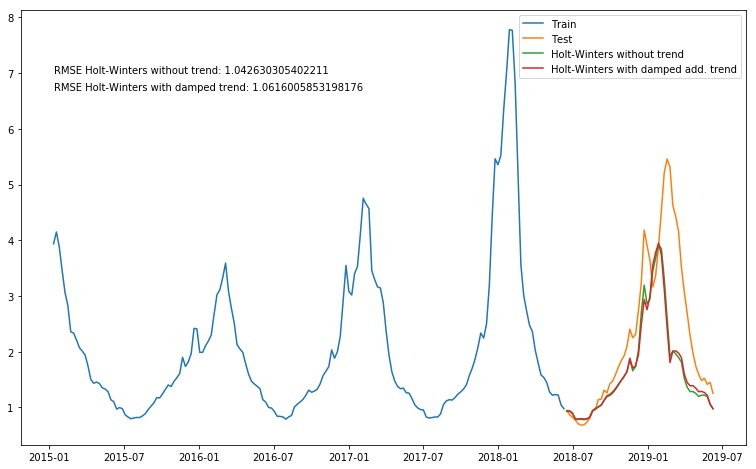

In [43]:
plt.figure(figsize=(13,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(holt_pred.index, holt_pred, label='Holt-Winters without trend')
plt.plot(holt2_pred.index, holt2_pred, label='Holt-Winters with damped add. trend')
plt.text(train.index[0], 7, "RMSE Holt-Winters without trend: " + str(rmse_holt))
plt.text(train.index[0], 6.7, "RMSE Holt-Winters with damped trend: " + str(rmse_holt2))
plt.legend(loc='best')
plt.show()

#### Holt-Winters - Triple Exponential Smoothing with more data

In [99]:
data = pd.read_csv("ili_national_more.csv", header=0)
data["date"] = pd.to_datetime(data.week.astype(str) + data.year.astype(str).add("-0"), format="%W%Y-%w")
data.set_index("date", inplace=True)
data = data.shift(-1, freq='W')
data = data.drop(['Unnamed: 0', 'region_type', 'region', 'year', 'week', 'weighted_ili',
       'age_0_4', 'age_25_49', 'age_25_64', 'age_5_24',
       'age_50_64', 'age_65', 'ilitotal', 'num_of_providers', 'total_patients',
       'week_start'], axis=1)
data = data.loc[~data.index.duplicated(keep='first')]
data = data.asfreq("W")

train2 = data.iloc[:772]
train2 = train2.fillna(method="ffill")
test2 = data.iloc[772:]
test2 = test2.fillna(method="ffill")

In [102]:
# no damped trend
from statsmodels.tsa.holtwinters import ExponentialSmoothing
more_holt = ExponentialSmoothing(train2, trend=None, seasonal="add", seasonal_periods=52)
more_holt_fit = more_holt.fit(optimized=True)
more_holt_pred = more_holt_fit.predict(start=test2.index[0], end=test2.index[-1])
# with damped trend
more_holt2 = ExponentialSmoothing(train2, trend="add", damped=True, seasonal="add", seasonal_periods=52)
more_holt2_fit = more_holt2.fit(optimized=True)
more_holt2_pred = more_holt2_fit.predict(start=test2.index[0], end=test2.index[-1])

In [103]:
rmse_more_holt = rmse(test2, more_holt_pred)
rmse_more_holt2 = rmse(test2, more_holt2_pred)

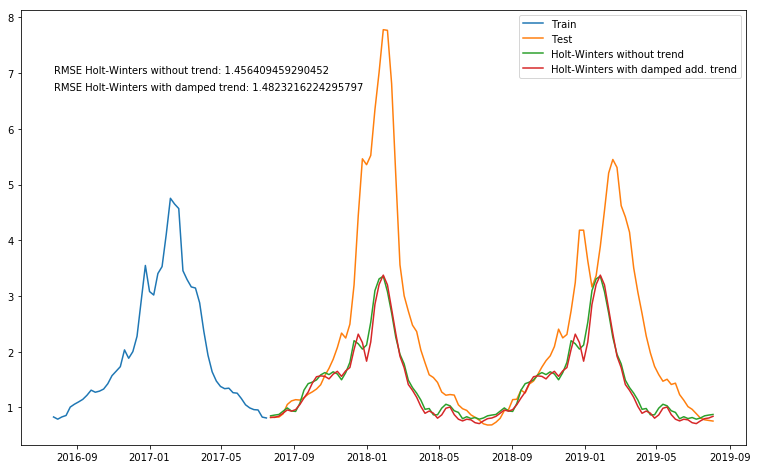

In [107]:
plt.figure(figsize=(13,8))
plt.plot(train2.index[720:], train2[720:], label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(more_holt_pred.index, more_holt_pred, label='Holt-Winters without trend')
plt.plot(more_holt2_pred.index, more_holt2_pred, label='Holt-Winters with damped add. trend')
plt.text(train2.index[720], 7, "RMSE Holt-Winters without trend: " + str(rmse_more_holt))
plt.text(train2.index[720], 6.7, "RMSE Holt-Winters with damped trend: " + str(rmse_more_holt2))
plt.legend(loc='best')
plt.show()

#### Rolling Window Regression